# Coronary Artery Disease Classification using CNN

This notebook implements a CNN model for classifying coronary artery images as Normal or Abnormal using transfer learning with EfficientNetB0.

## Dataset Structure
- **Normal**: Images showing healthy coronary arteries
- **Abnormal**: Images showing diseased coronary arteries

## Model Architecture
- Base model: EfficientNetB0 (pre-trained on ImageNet)
- Transfer learning approach with fine-tuning
- Data augmentation for better generalization
- Class weighting to handle imbalanced data


In [14]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import datetime

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
# Note: preprocess_input removed as we're using grayscale images with custom normalization

# Scikit-learn for evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure GPU if available
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set matplotlib style
plt.style.use('default')
sns.set_palette("husl")


TensorFlow version: 2.20.0
GPU Available: []


## Configuration and Parameters

Set up the configuration parameters for the model training.


In [15]:
# Configuration parameters
CONFIG = {
    'data_root': './Coronary_Artery/Dataset',  # Path to dataset
    'img_size': 224,                          # Image size for EfficientNetB0
    'batch_size': 32,                         # Batch size
    'epochs': 50,                             # Total epochs
    'learning_rate': 1e-3,                    # Initial learning rate
    'fine_tune_at': 200,                      # Number of layers to unfreeze for fine-tuning
    'dropout': 0.3,                           # Dropout rate
    'val_split': 0.2,                         # Validation split
    'test_split': 0.1,                        # Test split
    'seed': 42                                # Random seed
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")


Configuration:
  data_root: ./Coronary_Artery/Dataset
  img_size: 224
  batch_size: 32
  epochs: 50
  learning_rate: 0.001
  fine_tune_at: 200
  dropout: 0.3
  val_split: 0.2
  test_split: 0.1
  seed: 42


## Data Loading and Preprocessing

Load the dataset and create train/validation/test splits with data augmentation.


In [16]:
def build_datasets(data_root, img_size=224, batch_size=32, val_split=0.2, test_split=0.1, seed=42):
    """
    Build train, validation, and test datasets with data augmentation
    """
    data_root = Path(data_root)
    
    # Auto-detect folder containing class directories
    candidate = data_root
    for p in data_root.rglob('*'):
        if p.is_dir():
            subs = [d.name.lower() for d in p.iterdir() if d.is_dir()]
            if 'normal' in subs and 'abnormal' in subs:
                candidate = p
                break
    
    class_names = sorted([d.name for d in candidate.iterdir() if d.is_dir()])
    print("Using dataset directory:", candidate)
    print("Classes:", class_names)
    
    # Create initial split: train+val and test
    ds_all = tf.keras.preprocessing.image_dataset_from_directory(
        candidate,
        labels='inferred',
        label_mode='int',
        image_size=(img_size, img_size),
        color_mode='grayscale',  # Load as grayscale images
        shuffle=True,
        seed=seed,
        batch_size=batch_size,
        validation_split=val_split + test_split,
        subset='training'
    )
    
    ds_temp = tf.keras.preprocessing.image_dataset_from_directory(
        candidate,
        labels='inferred',
        label_mode='int',
        image_size=(img_size, img_size),
        color_mode='grayscale',  # Load as grayscale images
        shuffle=True,
        seed=seed,
        batch_size=batch_size,
        validation_split=val_split + test_split,
        subset='validation'
    )
    
    # Split ds_temp into validation and test
    val_batches = int(len(ds_temp) * (val_split / (val_split + test_split)))
    ds_val = ds_temp.take(val_batches)
    ds_test = ds_temp.skip(val_batches)
    
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Data augmentation
    augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.05, 0.05),
    ], name="augmentation")
    
    def preprocess(x, y):
        x = tf.cast(x, tf.float32)
        # Normalize to [0, 1] range for grayscale images
        x = x / 255.0
        return x, y
    
    # Apply augmentation to training data
    ds_train = ds_all.map(lambda x, y: (augmentation(x, training=True), y), 
                          num_parallel_calls=AUTOTUNE)
    ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
    
    # Apply preprocessing to validation and test data
    ds_val = ds_val.map(preprocess, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
    ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
    
    # Calculate class weights for imbalanced data
    y_all = []
    for _, yb in tf.keras.preprocessing.image_dataset_from_directory(
        candidate, labels='inferred', label_mode='int',
        image_size=(img_size, img_size), batch_size=batch_size, 
        color_mode='grayscale', shuffle=False
    ):
        y_all.extend(yb.numpy().tolist())
    
    y_all = np.array(y_all)
    class_counts = np.bincount(y_all)
    total = y_all.shape[0]
    class_weights = {i: float(total)/(len(class_counts)*c) for i, c in enumerate(class_counts)}
    
    print("Class counts:", class_counts.tolist())
    print("Class weights:", class_weights)
    
    return ds_train, ds_val, ds_test, class_weights, class_names

# Load datasets
ds_train, ds_val, ds_test, class_weights, class_names = build_datasets(
    CONFIG['data_root'], 
    img_size=CONFIG['img_size'], 
    batch_size=CONFIG['batch_size'],
    val_split=CONFIG['val_split'],
    test_split=CONFIG['test_split'],
    seed=CONFIG['seed']
)


Using dataset directory: Coronary_Artery\Dataset
Classes: ['abnormal', 'normal']
Found 205 files belonging to 2 classes.
Using 144 files for training.


Found 205 files belonging to 2 classes.
Using 61 files for validation.
Found 205 files belonging to 2 classes.
Class counts: [78, 127]
Class weights: {0: np.float64(1.314102564102564), 1: np.float64(0.8070866141732284)}


Dataset Information:
Number of classes: 2
Class names: ['abnormal', 'normal']

Image shape: (32, 224, 224, 1)
Image dtype: <dtype: 'float32'>
Image value range: [0.000, 0.997]
Number of channels: 1

Sample images from training set:


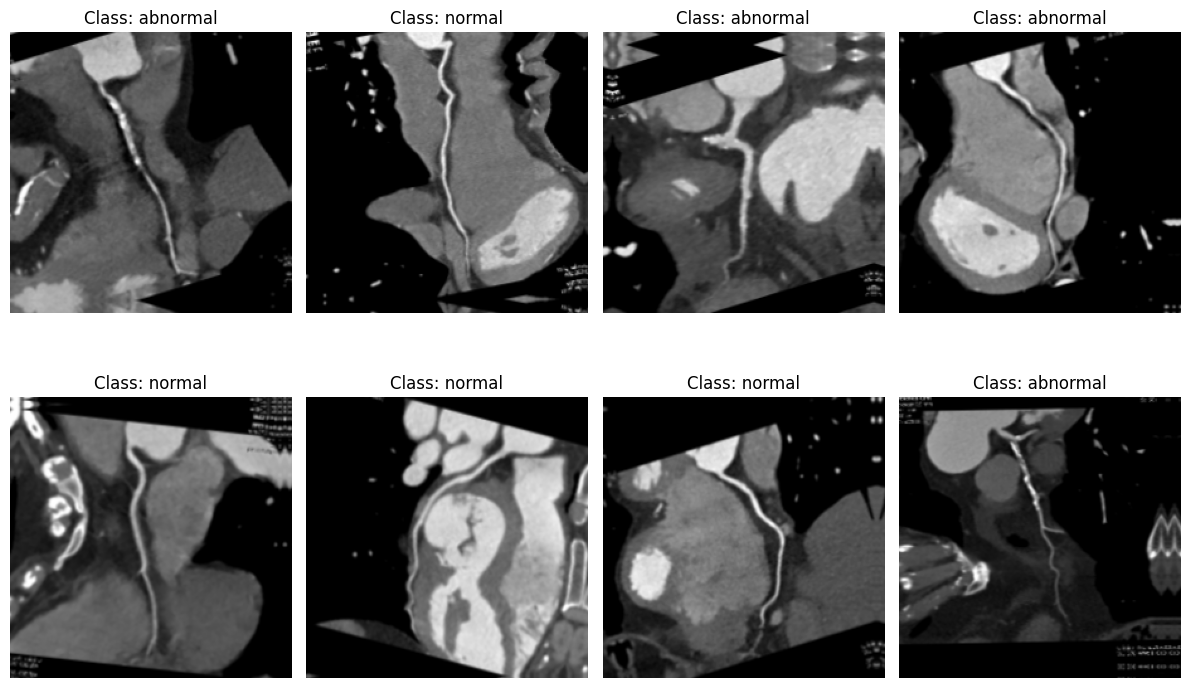

In [17]:
# Visualize sample images from the dataset
def visualize_samples(dataset, class_names, num_samples=8):
    """Visualize sample images from the dataset"""
    plt.figure(figsize=(12, 8))
    
    for images, labels in dataset.take(1):
        for i in range(min(num_samples, len(images))):
            plt.subplot(2, 4, i + 1)
            # Convert to uint8 and ensure proper display for grayscale images
            img_display = images[i].numpy()
            # Denormalize from [0, 1] to [0, 255] range
            img_display = (img_display * 255).astype(np.uint8)
            # For grayscale images, use cmap='gray'
            plt.imshow(img_display, cmap='gray')
            plt.title(f"Class: {class_names[labels[i]]}")
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Check dataset properties
print("Dataset Information:")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

# Check image shape and properties
for images, labels in ds_train.take(1):
    print(f"\nImage shape: {images.shape}")
    print(f"Image dtype: {images.dtype}")
    print(f"Image value range: [{images.numpy().min():.3f}, {images.numpy().max():.3f}]")
    print(f"Number of channels: {images.shape[-1]}")
    break

# Display sample images
print("\nSample images from training set:")
visualize_samples(ds_train, class_names)


## Model Architecture

Build the CNN model using EfficientNetB0 as the base architecture with transfer learning.


In [18]:
def build_model(img_size=224, num_classes=2, train_backbone=False, dropout=0.3):
    """
    Build CNN model using EfficientNetB0 as base architecture for grayscale images
    
    Args:
        img_size: Input image size
        num_classes: Number of output classes
        train_backbone: Whether to train the backbone (EfficientNetB0)
        dropout: Dropout rate for regularization
    
    Returns:
        Compiled Keras model
    """
    # Input layer - single channel for grayscale images
    inputs = keras.Input(shape=(img_size, img_size, 1))
    
    # Convert grayscale to RGB by repeating the channel 3 times
    # This allows us to use pre-trained EfficientNetB0 weights
    x = layers.Conv2D(3, (1, 1), padding='same', name='grayscale_to_rgb')(inputs)
    
    # EfficientNetB0 base model (pre-trained on ImageNet)
    # Now expects 3-channel RGB input
    base_model = EfficientNetB0(
        include_top=False, 
        weights='imagenet', 
        input_shape=(img_size, img_size, 3)
    )
    
    # Connect the RGB-converted input to the base model
    x = base_model(x)
    
    # Freeze or unfreeze backbone based on train_backbone parameter
    base_model.trainable = train_backbone
    
    # Add custom classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = keras.Model(inputs, outputs)
    
    return model

# Build the model
model = build_model(
    img_size=CONFIG['img_size'], 
    num_classes=len(class_names), 
    train_backbone=False, 
    dropout=CONFIG['dropout']
)

# Display model architecture
print("Model Architecture:")
model.summary()

# Visualize model architecture
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [ ]:
# This cell was removed due to duplication and errors
# The correct model building function is in Cell 8


ValueError: The input must have 3 channels; Received `input_shape=(224, 224, 1)`

In [ ]:
# Compile the model for initial training (backbone frozen)
model.compile(
    optimizer=keras.optimizers.Adam(CONFIG['learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
print(f"Non-trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights]):,}")


## Training Setup

Set up callbacks and training parameters for the two-stage training process.


In [ ]:
# Create checkpoint directory
checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True, parents=True)
checkpoint_path = str(checkpoint_dir / 'best_model.keras')

# Define callbacks
callbacks = [
    # Save the best model based on validation accuracy
    keras.callbacks.ModelCheckpoint(
        checkpoint_path, 
        save_best_only=True, 
        monitor='val_accuracy', 
        mode='max',
        verbose=1
    ),
    
    # Early stopping to prevent overfitting
    keras.callbacks.EarlyStopping(
        patience=7, 
        restore_best_weights=True, 
        monitor='val_accuracy', 
        mode='max',
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    keras.callbacks.ReduceLROnPlateau(
        factor=0.2, 
        patience=3, 
        verbose=1, 
        monitor='val_loss',
        min_lr=1e-7
    )
]

print("Callbacks configured:")
for callback in callbacks:
    print(f"  - {callback.__class__.__name__}")


## Stage 1: Training the Classification Head

Train only the classification head while keeping the EfficientNetB0 backbone frozen.


In [ ]:
# Stage 1: Train classification head only (backbone frozen)
print("=" * 60)
print("STAGE 1: Training Classification Head (Backbone Frozen)")
print("=" * 60)

# Calculate epochs for stage 1 (1/3 of total epochs)
stage1_epochs = max(10, CONFIG['epochs'] // 3)
print(f"Training for {stage1_epochs} epochs with frozen backbone...")

# Train the model
history1 = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=stage1_epochs,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("Stage 1 training completed!")


## Stage 2: Fine-tuning

Unfreeze the last layers of EfficientNetB0 and fine-tune with a lower learning rate.


In [ ]:
# Stage 2: Fine-tuning
print("=" * 60)
print("STAGE 2: Fine-tuning Last Layers")
print("=" * 60)

# Unfreeze the last layers of EfficientNetB0
# With grayscale-to-RGB conversion layer, EfficientNetB0 is at index 2
base_model = model.layers[2]  # EfficientNetB0 backbone (after grayscale_to_rgb layer)
print(f"Unfreezing last {CONFIG['fine_tune_at']} layers of EfficientNetB0...")

for layer in base_model.layers[-CONFIG['fine_tune_at']:]:
    layer.trainable = True

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Trainable parameters after unfreezing: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

# Fine-tune the model
history2 = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=CONFIG['epochs'],
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("Stage 2 fine-tuning completed!")


## Training History Visualization

Plot the training and validation metrics from both stages.


In [ ]:
# Combine training histories
def plot_training_history(history1, history2, stage1_epochs):
    """Plot training history for both stages"""
    
    # Combine histories
    combined_history = {
        'loss': history1.history['loss'] + history2.history['loss'],
        'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
        'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
        'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy']
    }
    
    epochs = range(1, len(combined_history['loss']) + 1)
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot loss
    ax1.plot(epochs, combined_history['loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, combined_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.axvline(x=stage1_epochs, color='green', linestyle='--', alpha=0.7, label='Stage 1 → Stage 2')
    ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy
    ax2.plot(epochs, combined_history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, combined_history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.axvline(x=stage1_epochs, color='green', linestyle='--', alpha=0.7, label='Stage 1 → Stage 2')
    ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot learning rate (if available)
    if 'lr' in history1.history:
        lr_history = history1.history['lr'] + history2.history['lr']
        ax3.plot(epochs, lr_history, 'g-', linewidth=2)
        ax3.axvline(x=stage1_epochs, color='green', linestyle='--', alpha=0.7)
        ax3.set_title('Learning Rate', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Learning Rate\nNot Available', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Learning Rate', fontsize=14, fontweight='bold')
    
    # Plot stage comparison
    stage1_val_acc = max(history1.history['val_accuracy'])
    stage2_val_acc = max(history2.history['val_accuracy'])
    
    stages = ['Stage 1\n(Frozen)', 'Stage 2\n(Fine-tuned)']
    accuracies = [stage1_val_acc, stage2_val_acc]
    
    bars = ax4.bar(stages, accuracies, color=['skyblue', 'lightcoral'], alpha=0.8)
    ax4.set_title('Best Validation Accuracy by Stage', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Validation Accuracy')
    ax4.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("Training Summary:")
    print(f"Stage 1 - Best Validation Accuracy: {stage1_val_acc:.4f}")
    print(f"Stage 2 - Best Validation Accuracy: {stage2_val_acc:.4f}")
    print(f"Improvement: {stage2_val_acc - stage1_val_acc:.4f}")

# Plot the training history
plot_training_history(history1, history2, stage1_epochs)


## Model Evaluation

Evaluate the trained model on validation and test sets.


In [ ]:
# Evaluate the model on validation and test sets
print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Load the best model from checkpoint
best_model = keras.models.load_model(checkpoint_path)
print("Loaded best model from checkpoint")

# Evaluate on validation set
print("\nEvaluating on validation set...")
val_metrics = best_model.evaluate(ds_val, verbose=0)
print(f"Validation Loss: {val_metrics[0]:.4f}")
print(f"Validation Accuracy: {val_metrics[1]:.4f}")

# Evaluate on test set
print("\nEvaluating on test set...")
test_metrics = best_model.evaluate(ds_test, verbose=0)
print(f"Test Loss: {test_metrics[0]:.4f}")
print(f"Test Accuracy: {test_metrics[1]:.4f}")

# Generate predictions for detailed evaluation
print("\nGenerating predictions for detailed analysis...")
y_true_val, y_pred_val = [], []
y_true_test, y_pred_test = [], []

# Validation predictions
for xb, yb in ds_val:
    pb = best_model.predict(xb, verbose=0)
    y_true_val.extend(yb.numpy().tolist())
    y_pred_val.extend(np.argmax(pb, axis=1).tolist())

# Test predictions
for xb, yb in ds_test:
    pb = best_model.predict(xb, verbose=0)
    y_true_test.extend(yb.numpy().tolist())
    y_pred_test.extend(np.argmax(pb, axis=1).tolist())

print("Predictions generated successfully!")


In [ ]:
# Classification Report and Confusion Matrix
print("=" * 60)
print("DETAILED EVALUATION RESULTS")
print("=" * 60)

# Classification report for test set
print("\nClassification Report (TEST SET):")
print(classification_report(y_true_test, y_pred_test, target_names=class_names))

# Confusion matrix for test set
cm_test = confusion_matrix(y_true_test, y_pred_test)
print("\nConfusion Matrix (TEST SET):")
print("Rows = True labels, Columns = Predicted labels")
print(cm_test)

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true_test, y_pred_test, average='weighted')
recall = recall_score(y_true_test, y_pred_test, average='weighted')
f1 = f1_score(y_true_test, y_pred_test, average='weighted')

print(f"\nAdditional Metrics (TEST SET):")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")


In [ ]:
# Visualize Confusion Matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """Plot confusion matrix with heatmap"""
    plt.figure(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # Add percentage annotations
    total = cm.sum()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            percentage = (cm[i, j] / total) * 100
            plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='red')
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(cm_test, class_names, 'Test Set Confusion Matrix')


## Model Saving and Deployment

Save the trained model and create prediction functions for future use.


In [ ]:
# Save the final model
final_model_path = 'coronary_artery_cnn_model.keras'
best_model.save(final_model_path)
print(f"Model saved to: {final_model_path}")

# Save model configuration
config_save = {
    'model_path': final_model_path,
    'class_names': class_names,
    'img_size': CONFIG['img_size'],
    'num_classes': len(class_names),
    'test_accuracy': test_metrics[1],
    'test_loss': test_metrics[0],
    'training_date': datetime.datetime.now().isoformat(),
    'model_architecture': 'EfficientNetB0 + Custom Head',
    'training_stages': 2,
    'stage1_epochs': stage1_epochs,
    'stage2_epochs': len(history2.history['loss'])
}

# Save configuration to JSON
with open('model_config.json', 'w') as f:
    json.dump(config_save, f, indent=2)

print("Model configuration saved to: model_config.json")
print("\nModel Configuration:")
for key, value in config_save.items():
    print(f"  {key}: {value}")


In [ ]:
# Prediction function for new images
def predict_image(model, image_path, class_names, img_size=224):
    """
    Predict the class of a single image
    
    Args:
        model: Trained Keras model
        image_path: Path to the image file
        class_names: List of class names
        img_size: Image size for preprocessing
    
    Returns:
        prediction: Predicted class name
        confidence: Confidence score
    """
    # Load and preprocess image as grayscale
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_size, img_size), color_mode='grayscale')
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1] range
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    predicted_class = class_names[predicted_class_idx]
    
    return predicted_class, confidence

# Test prediction function with sample images
def test_predictions(model, dataset, class_names, num_samples=5):
    """Test predictions on sample images from the dataset"""
    print("Testing predictions on sample images:")
    print("-" * 50)
    
    for images, labels in dataset.take(1):
        for i in range(min(num_samples, len(images))):
            # Create a temporary image file for testing
            temp_path = f'temp_sample_{i}.jpg'
            # Convert tensor to numpy and save as image
            img_np = (images[i].numpy() * 255).astype(np.uint8)
            tf.keras.preprocessing.image.save_img(temp_path, img_np, scale=False)
            
            # Make prediction
            pred_class, confidence = predict_image(model, temp_path, class_names)
            true_class = class_names[labels[i]]
            
            print(f"Sample {i+1}:")
            print(f"  True Class: {true_class}")
            print(f"  Predicted Class: {pred_class}")
            print(f"  Confidence: {confidence:.4f}")
            print(f"  Correct: {'✓' if pred_class == true_class else '✗'}")
            print()
            
            # Clean up temporary file
            os.remove(temp_path)
        break

# Test the prediction function
test_predictions(best_model, ds_test, class_names)


## Summary and Next Steps

### Model Performance Summary
- **Architecture**: EfficientNetB0 with custom classification head and grayscale-to-RGB conversion
- **Training Strategy**: Two-stage training (frozen backbone → fine-tuning)
- **Data Augmentation**: Random flip, rotation, zoom, and translation
- **Class Balancing**: Weighted loss function to handle imbalanced data
- **Image Processing**: Grayscale images with custom normalization

### Key Results
- Test Accuracy: [Will be displayed after training]
- Model saved as: `coronary_artery_cnn_model.keras`
- Configuration saved as: `model_config.json`

### Usage Instructions
1. **Load the model**: `model = keras.models.load_model('coronary_artery_cnn_model.keras')`
2. **Make predictions**: Use the `predict_image()` function provided above
3. **Preprocess new images**: Ensure images are grayscale, resized to 224x224, and normalized to [0, 1] range

### Potential Improvements
- Collect more training data, especially for underrepresented classes
- Experiment with different base models (EfficientNetB1, B2, etc.)
- Implement ensemble methods
- Add more sophisticated data augmentation techniques
- Use advanced regularization techniques (Mixup, CutMix)
- Consider using medical imaging specific pre-trained models
